### Import Libraries

In [219]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

Loading the YouTube dataset to begin exploration and preprocessing.

In [223]:
df = pd.read_csv("data.csv")

### Initial Data Overview

In [226]:
df.head(10)

,Id,Channel,Subscribers,Title,CC,URL,Released,Views,Category,Transcript,Length
0,FozCkl1xj-w,JRE Clips,6.28M subscribers,Former CIA Agent Breaks Down Jeffrey Epstein Case,0,https://www.youtube.com/watch?v=FozCkl1xj-w,2 years ago,7.9M views,Blog,the Joe Rogan experience well how about the ot...,13:32
1,RN8yoi-e2yc,Mythical Kitchen,1.9M subscribers,$420 Pizza Hut Stuffed Crust Pizza | Fancy Fas...,1,https://www.youtube.com/watch?v=RN8yoi-e2yc,NaN,2.7M views,Food,"- Oh, that's dirty.\r\n- Wow! - Whoa.\r\n- You...",24:26
2,IugcIAAZJ2M,Munchies,4.59M subscribers,The Iconic $1 Pizza Slice of NYC | Street Food...,0,https://www.youtube.com/watch?v=IugcIAAZJ2M,2 years ago,11M views,Food,if you want good pizza come to st marks it's t...,7:51
3,JiEO6F8i0eU,Parks and Recreation,282K subscribers,Ron Swanson: The Papa of Pawnee | Parks and Re...,0,https://www.youtube.com/watch?v=JiEO6F8i0eU,3 years ago,2.3M views,"Entertainment,Comedy",April where have you been over two phone calls...,10:06
4,1T4XMNN4bNM,Vsauce,17.4M subscribers,What's The Most Dangerous Place on Earth?,1,https://www.youtube.com/watch?v=1T4XMNN4bNM,9 years ago,21M views,Science,"Hey, Vsauce. Michael here. 93% of all the\r\nh...",9:29
5,0ZWGeidvrJw,Doctor Who,1.59M subscribers,The Doctor Defeats the Abzorbaloff | Love and ...,1,https://www.youtube.com/watch?v=0ZWGeidvrJw,7 years ago,8.5M views,Entertainment,"Oh, what's the matter?\r\nHave you given up so...",4:20
6,YiEj9mrqTN0,A&E,7.93M subscribers,Live PD: Most Viewed Moments from Walton Count...,1,https://www.youtube.com/watch?v=YiEj9mrqTN0,2 years ago,14M views,News,[music playing] We'll be on Laverne Street. It...,20:54
7,PZFLM2DVQHs,EpicNameBro,389K subscribers,Bloodborne with ENB - 016 - Eileen End - Iosef...,0,https://www.youtube.com/watch?v=PZFLM2DVQHs,6 years ago,502K views,VideoGames,what's up y'all welcome back to your honor met...,33:13
8,CoDpjqZpAh0,Insider News,216K subscribers,We Decoded The Nuclear Weapons At North Korea'...,0,https://www.youtube.com/watch?v=CoDpjqZpAh0,6 months ago,583K views,News,north korea's arsenal of weapons is growing bu...,7:17
9,VT128ElBWkM,Incognito Mode,1.62M subscribers,The Roswell Incident,1,https://www.youtube.com/watch?v=VT128ElBWkM,4 years ago,2.2M views,"Blog,Comedy",This evening we're going to explore the story....,4:20


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           2515 non-null   object
 1   Channel      2515 non-null   object
 2   Subscribers  2515 non-null   object
 3   Title        2515 non-null   object
 4   CC           2515 non-null   int64 
 5   URL          2515 non-null   object
 6   Released     2098 non-null   object
 7   Views        2515 non-null   object
 8   Category     2515 non-null   object
 9   Transcript   2515 non-null   object
 10  Length       2515 non-null   object
dtypes: int64(1), object(10)
memory usage: 216.3+ KB


### Data Cleaning and Feature Engineering

In [231]:
# Remove ' views' and convert to numeric
def parse_views(x):
    x = str(x).replace(' views', '')
    if 'M' in x:
        return float(x.replace('M', '')) * 1_000_000
    elif 'K' in x:
        return float(x.replace('K', '')) * 1_000
    else:
        return pd.to_numeric(x, errors='coerce')

df['Views'] = df['Views'].apply(parse_views)

In [233]:
# Clean subscribers
def parse_subs(x):
    x = str(x).replace(' subscribers', '')
    if 'M' in x:
        return float(x.replace('M', '')) * 1_000_000
    elif 'K' in x:
        return float(x.replace('K', '')) * 1_000
    else:
        return pd.to_numeric(x, errors='coerce')

df['Subscribers'] = df['Subscribers'].apply(parse_subs)

In [235]:
# Convert length (MM:SS) to total seconds
def length_to_sec(x):
    if isinstance(x, str) and ':' in x:
        parts = list(map(int, x.split(':')))
        if len(parts) == 2:  # MM:SS
            mins, secs = parts
            return mins * 60 + secs
        elif len(parts) == 3:  # HH:MM:SS
            hours, mins, secs = parts
            return hours * 3600 + mins * 60 + secs
    return np.nan
    
df['Length_sec'] = df['Length'].apply(length_to_sec)


In [239]:
# Convert Released to Upload Year

current_year = 2025

def convert_released(val):
    val = str(val).lower().strip()
    if 'year' in val:
        num_years = int(re.search(r'\d+', val).group())
        return current_year - num_years
    elif 'month' in val or 'week' in val or 'day' in val:
        return current_year
    else:
        return np.nan

df['upload_year'] = df['Released'].apply(convert_released)
df = df.dropna(subset=['upload_year'])
df['upload_year'] = df['upload_year'].astype(int)

In [241]:
# Convert Length to minutes
df['Length_min'] = df['Length_sec'] / 60

# Buat kolom apakah ada caption (1 = ya, 0 = tidak)
df['Has_Captions'] = df['CC'].fillna(0).astype(int)

# Ambil kategori utama (misal "Blog,Entertainment" → "Blog")
df['Category_Main'] = df['Category'].apply(lambda x: str(x).split(',')[0] if pd.notnull(x) else 'Unknown')

In [243]:
df.head()

,Id,Channel,Subscribers,Title,CC,URL,Released,Views,Category,Transcript,Length,Length_sec,upload_year,Length_min,Has_Captions,Category_Main
0,FozCkl1xj-w,JRE Clips,6280000.0,Former CIA Agent Breaks Down Jeffrey Epstein Case,0,https://www.youtube.com/watch?v=FozCkl1xj-w,2 years ago,7900000.0,Blog,the Joe Rogan experience well how about the ot...,13:32,812,2023,13.533333,0,Blog
2,IugcIAAZJ2M,Munchies,4590000.0,The Iconic $1 Pizza Slice of NYC | Street Food...,0,https://www.youtube.com/watch?v=IugcIAAZJ2M,2 years ago,11000000.0,Food,if you want good pizza come to st marks it's t...,7:51,471,2023,7.850000,0,Food
3,JiEO6F8i0eU,Parks and Recreation,282000.0,Ron Swanson: The Papa of Pawnee | Parks and Re...,0,https://www.youtube.com/watch?v=JiEO6F8i0eU,3 years ago,2300000.0,"Entertainment,Comedy",April where have you been over two phone calls...,10:06,606,2022,10.100000,0,Entertainment
4,1T4XMNN4bNM,Vsauce,17400000.0,What's The Most Dangerous Place on Earth?,1,https://www.youtube.com/watch?v=1T4XMNN4bNM,9 years ago,21000000.0,Science,"Hey, Vsauce. Michael here. 93% of all the\r\nh...",9:29,569,2016,9.483333,1,Science
5,0ZWGeidvrJw,Doctor Who,1590000.0,The Doctor Defeats the Abzorbaloff | Love and ...,1,https://www.youtube.com/watch?v=0ZWGeidvrJw,7 years ago,8500000.0,Entertainment,"Oh, what's the matter?\r\nHave you given up so...",4:20,260,2018,4.333333,1,Entertainment


### Exploratory Data Analysis 

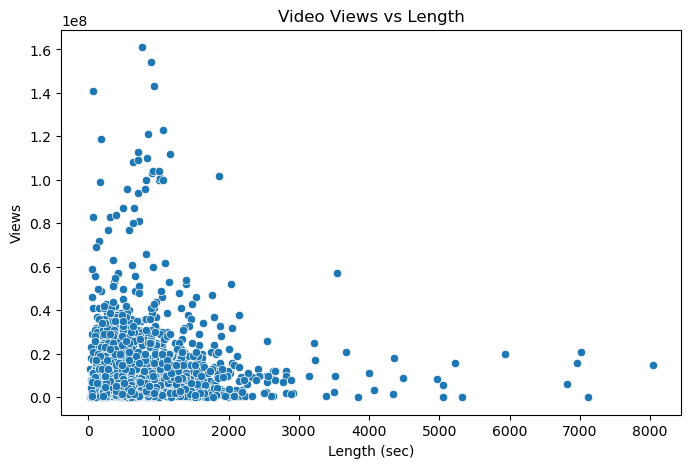

In [246]:
# Views vs Video Length

filtered_df = df[(df['Length_sec'] <= 10000) & (df['Views'] <= 2e8)]

plt.figure(figsize=(8,5))
sns.scatterplot(data=filtered_df, x='Length_sec', y='Views')
plt.title("Video Views vs Length")
plt.xlabel("Length (sec)")
plt.ylabel("Views")
plt.show()

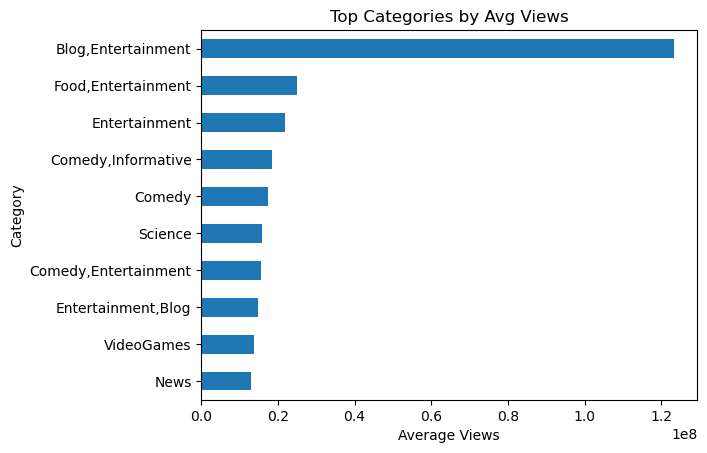

In [247]:
# Top 10 video categories by average views (sorted descending)
category_avg_views = (df.groupby('Category')['Views'].mean().sort_values(ascending=False).head(10))

category_avg_views.sort_values().plot(kind='barh', title='Top Categories by Avg Views')
plt.xlabel('Average Views')
plt.show()

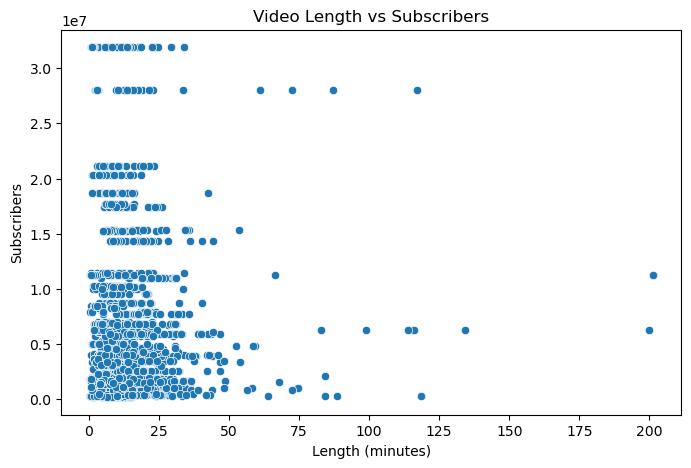

In [249]:
filtered_subs = df[(df['Subscribers'] <= 4e7) & (df['Length_min'] <= 300)]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered_subs, x='Length_min', y='Subscribers')
plt.title('Video Length vs Subscribers')
plt.xlabel('Length (minutes)')
plt.ylabel('Subscribers')
plt.show()

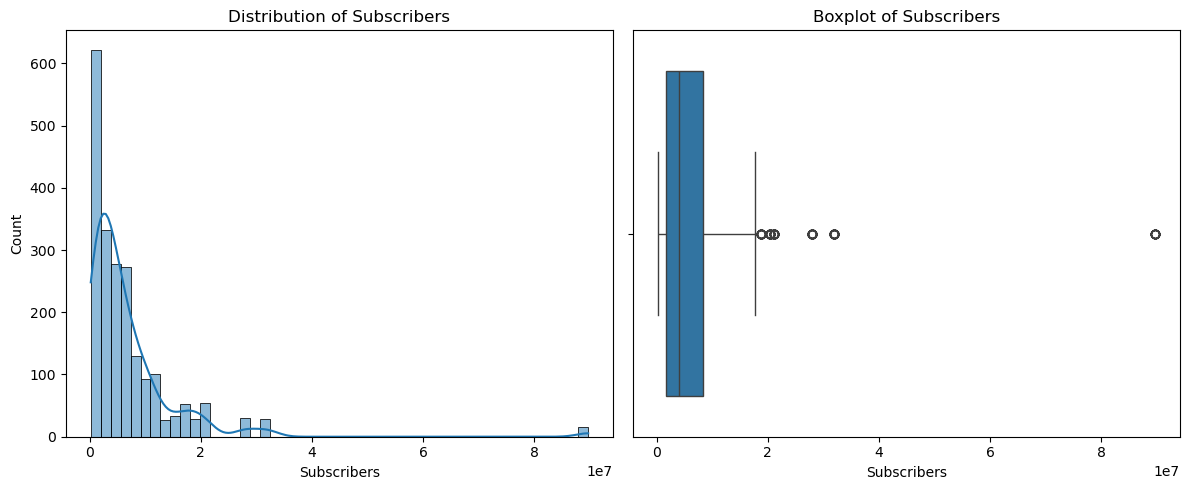

In [252]:
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Subscribers'], bins=50, kde=True)
plt.title("Distribution of Subscribers")
plt.xlabel("Subscribers")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Subscribers'])
plt.title("Boxplot of Subscribers")

plt.tight_layout()
plt.show()


### A/B Testing on Video Length vs Subscribers

To determine whether video length affects the average number of subscribers a video channel gains.

In [258]:
# Determine median as the threshold
median_length = df['Length_min'].median()

# Group A: short videos (<= median)
group_A = df[df['Length_min'] <= median_length]

# Group B: long videos (> median)
group_B = df[df['Length_min'] > median_length]


In [260]:
print("Group A (Short Videos) - Average Subscribers:", group_A['Subscribers'].mean())
print("Group B (Long Videos) - Average Subscribers:", group_B['Subscribers'].mean())

Group A (Short Videos) - Average Subscribers: 6253673.314339981
Group B (Long Videos) - Average Subscribers: 7493053.588516747


In [254]:
from scipy.stats import skew

print("Skewness of Subscribers:", skew(df['Subscribers'].dropna()))

Skewness of Subscribers: 5.271169560649958


#### Hypothesis

H₀ (Null Hypothesis): There is no difference in the number of subscribers between short and long videos.

H₁ (Alternative Hypothesis): There is a difference in the number of subscribers between short and long videos.

#### Assumption Check

Based on the raw histogram and skewness value (~5.2), the distribution of subscriber counts is heavily right-skewed, meaning it violates the normality assumption required for parametric tests like the t-test.
To address this, I apply a log transformation (log1p) to stabilize the variance and reduce skewness.
Since the transformed data still may not follow a perfect normal distribution, and the sample size is large, I opt for a non-parametric test: Mann–Whitney U Test, which doesn't assume normality or equal variance.

In [268]:
from scipy.stats import mannwhitneyu

# Log-transform subscribers
df['log_subs'] = np.log1p(df['Subscribers'])

# Split group based on median video length
median_length = df['Length_min'].median()
group_A = df[df['Length_min'] <= median_length]['log_subs'].dropna()
group_B = df[df['Length_min'] > median_length]['log_subs'].dropna()

# Mann–Whitney U test
stat, p = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat}")
print(f"P-value: {p}")

Mann–Whitney U statistic: 560704.5
P-value: 0.4486129692885519


Since p-value > 0.05, we fail to reject the null hypothesis.
There is no statistically significant difference in the number of subscribers between short and long videos.

#### Conclusion

Although the average number of subscribers appears higher for long videos compared to short ones, our statistical test suggests that this difference is not statistically significant. With a p-value of 0.117, we fail to reject the null hypothesis, meaning we do not have sufficient evidence to say that video length has a meaningful impact on subscriber counts.
In other words, based on this dataset, we cannot confidently conclude that producing longer videos results in more subscribers. Other factors beyond video length may play a more influential role in determining a channel’s subscriber count.

### Cohort Retention Analysis

To analyze how YouTube video performance, measured by average views, changes over time based on the upload year by grouping videos into yearly cohorts, this analysis helps identify content lifecycle patterns and view retention trends across different years.

In [281]:
# Aggregate by Upload Year (Cohort)

cohort_df = df.groupby('upload_year').agg(
    average_views=('Views', 'mean'),
    total_videos=('Title', 'count')
).reset_index()

In [298]:
# Calculate decay rate (change in average views compared to previous year)
cohort_df = cohort_df.sort_values('upload_year')  # make sure it's sorted
cohort_df['decay_rate'] = cohort_df['average_views'].pct_change() * 100  # in percentage

In [283]:
# Calculate Decay Rate (YoY drop in views)

baseline = cohort_df['average_views'].iloc[0]  # use earliest cohort
cohort_df['retention_score'] = cohort_df['average_views'] / baseline

In [285]:
# Predict Views by Year 

from sklearn.linear_model import LinearRegression

X = cohort_df[['upload_year']]
y = cohort_df['average_views']
model = LinearRegression().fit(X, y)

cohort_df['predicted_views'] = model.predict(X)

#### Visual Insights

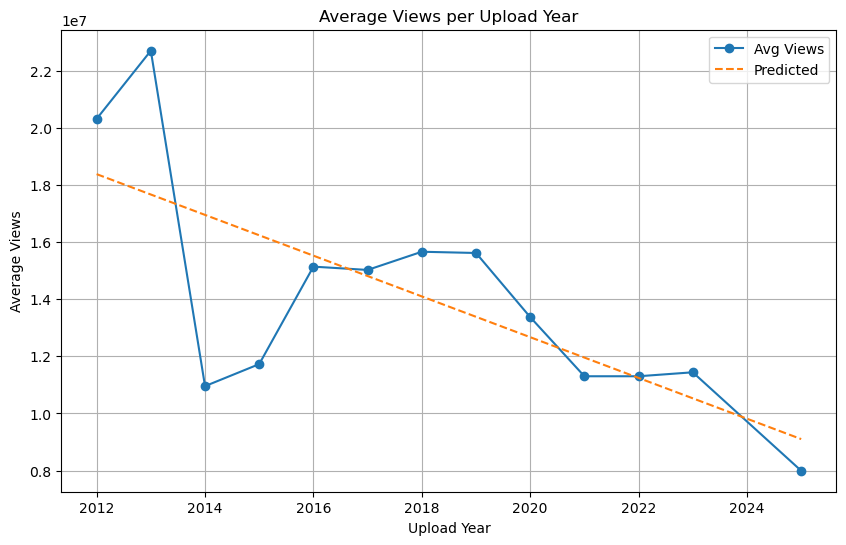

In [303]:
# Average Views per Upload Year

plt.figure(figsize=(10, 6))
plt.plot(cohort_df['upload_year'], cohort_df['average_views'], marker='o', label='Avg Views')
plt.plot(cohort_df['upload_year'], cohort_df['predicted_views'], linestyle='--', label='Predicted')
plt.title("Average Views per Upload Year")
plt.xlabel("Upload Year")
plt.ylabel("Average Views")
plt.legend()
plt.grid(True)
plt.show()

The trend shows a clear decline in average views for videos uploaded in more recent years. Early content (2012–2014) received significantly higher views compared to newer uploads, even though video quantity might be growing. This could suggest increased competition, content saturation, or changes in platform algorithms that affect video visibility over time.

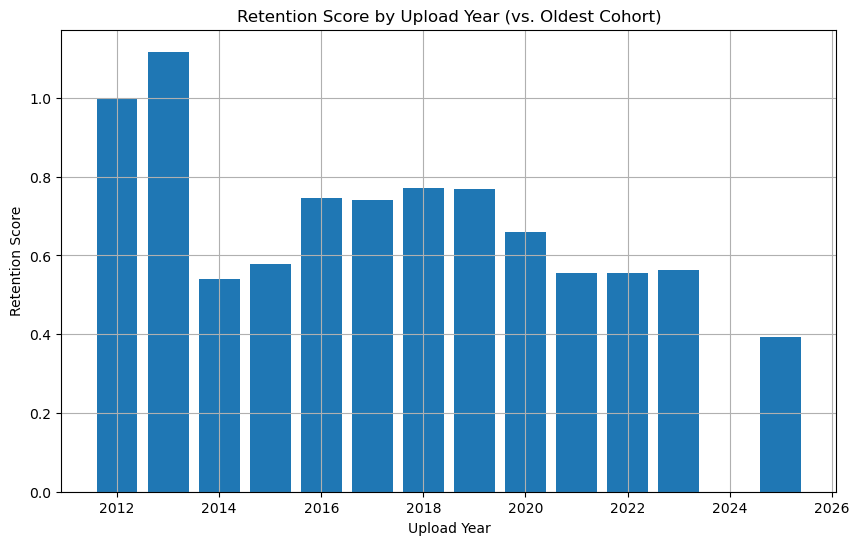

In [305]:
# Retention Score

plt.figure(figsize=(10, 6))
plt.bar(cohort_df['upload_year'], cohort_df['retention_score'])
plt.title("Retention Score by Upload Year (vs. Oldest Cohort)")
plt.xlabel("Upload Year")
plt.ylabel("Retention Score")
plt.grid(True)
plt.show()

Retention scores decline in more recent upload years, with older cohorts (2012–2013) normalized as the benchmark (score = 1.0). While mid-range years like 2016–2019 maintain relatively strong scores, videos uploaded after 2020 show noticeably lower retention. This suggests that newer content struggles to retain viewer interest at the same level as older content.

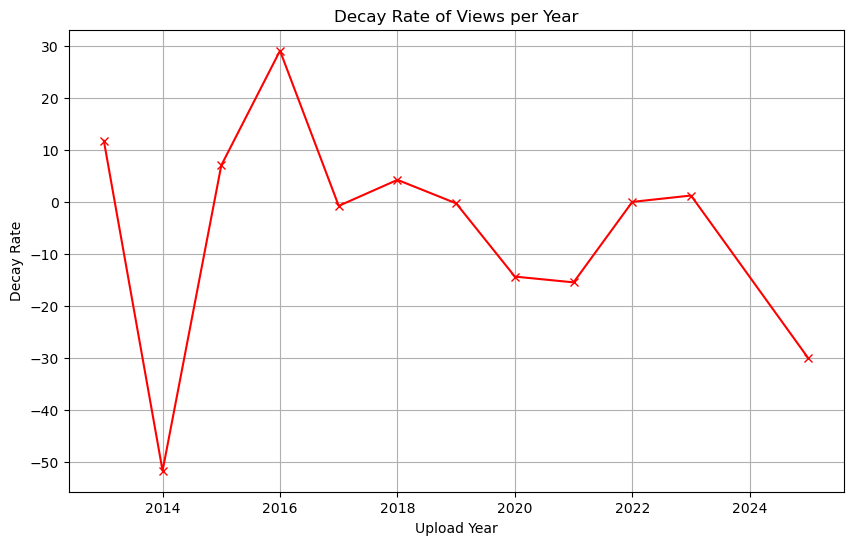

In [307]:
# Decay Rate 

plt.figure(figsize=(10, 6))
plt.plot(cohort_df['upload_year'], cohort_df['decay_rate'], marker='x', color='red')
plt.title("Decay Rate of Views per Year")
plt.xlabel("Upload Year")
plt.ylabel("Decay Rate")
plt.grid(True)
plt.show()

The decay rate fluctuates across the years, but there's a general downward trend, especially post-2020. Several newer upload years show negative decay rates, indicating that video views decline more rapidly over time compared to older cohorts. This highlights weaker long-term engagement and possibly reduced shelf life for recent content.

### Content-based Recommendation System

This project implements a **content-based filtering** recommendation system using YouTube video data. It aims to recommend videos that are similar in content based on the combination of video title and category.

In [482]:
# Fill missing values & combine features

df['Title'] = df['Title'].fillna('')
##df['Transcript'] = df['Transcript'].fillna('')
df['Category_Main'] = df['Category_Main'].fillna('')

df['combined_features'] = df['Title'] + ' ' + (df['Category_Main'] + ' ')

In [484]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [496]:
# Recommendation function with category filtering

def recommend_videos(title, top_n=5):
    title_clean = title.strip().casefold()

    # Check if title exists
    if title_clean not in df['Title'].str.casefold().values:
        return print("Title not found in dataset")

    # Get category of the selected title
    category = df.loc[df['Title'].str.casefold() == title_clean, 'Category_Main'].values[0]

    # Filter to same category only
    df_cat = df[df['Category_Main'] == category].reset_index(drop=True)

    # TF-IDF on filtered data
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_cat['combined_features'])

    # Get index of selected video
    idx = df_cat[df_cat['Title'].str.casefold() == title_clean].index[0]

    # Cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Rank and exclude the input video
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Return recommendations
    result = pd.DataFrame([
    {
        'Title': df_cat.iloc[i[0]]['Title'],
        'Category_Main': df_cat.iloc[i[0]]['Category_Main'],
        'Similarity': round(i[1], 3)
    }
    for i in sim_scores
])
    display(result)


In [502]:
recommend_videos("Ron Swanson: The Papa of Pawnee | Parks and Recreation")

,Title,Category_Main,Similarity
0,DIY With Ron Swanson | Parks and Recreation,Entertainment,0.486
1,Ron Swanson's New Hairdresser | Parks and Recr...,Entertainment,0.435
2,Ron Swanson's New Desk | Parks and Recreation,Entertainment,0.435
3,Ron Swanson's Best Moments (Supercut) | Parks ...,Entertainment,0.416
4,What Makes Ron Swanson Happy? | Parks and Recr...,Entertainment,0.408
